In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.ndimage import median_filter
from scipy.interpolate import interp1d
import json
import os
import glob
import pickle
import warnings
import re

warnings.filterwarnings('ignore')

# File I/O Functions

In [43]:
# =====================================================================

# FILE I/O FUNCTIONS

# =====================================================================

def load_subject_data(json_path, pkl_path):
    """Load JSON and PKL files for a subject."""
    # Load JSON
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Load PKL
    with open(pkl_path, 'rb') as f:
        eye_pkl = pickle.load(f)

    # Convert to DataFrame
    eye_pkl = pd.DataFrame(eye_pkl)

    return data, eye_pkl

def extract_subject_id(filename):
    """Extract subject ID from filename."""
    match = re.search(r"(\d{4}_\d{4})_.*?DESKTOP-([A-Z0-9]+)", filename)
    if match:
        result = f"{match.group(1)}_{match.group(2)}"
        return result
    return None

def get_subject_files(json_dir, pkl_dir):
    """
    Find all matching JSON and PKL files.
    
    Parameters:
    -----------
    json_dir : str
        Directory containing JSON files
    pkl_dir : str
        Directory containing PKL files
    
    Returns:
    --------
    subject_files : dict
        Dictionary mapping subject_id to file paths
    """
    json_files = glob.glob(os.path.join(json_dir, '*.json'))
    pkl_files = glob.glob(os.path.join(pkl_dir, '*.pkl'))

    subject_files = {}

    for json_path in json_files:
        subject_id = extract_subject_id(json_path)
        pkl_path = next((f for f in pkl_files if subject_id in f), None)
        
        if os.path.exists(pkl_path):
            subject_files[subject_id] = {
                'json': json_path,
                'pkl': pkl_path
            }
    
    return subject_files

# Validation

In [45]:
# =====================================================================

# VALIDATION FUNCTIONS

# =====================================================================

def validate_trial_comprehensive(trial, trial_idx, data, eye_pkl):
    """
    Comprehensive validation of a single trial.
    
    Checks:
    1. Has submit event
    2. Has show screen event
    3. Has eye tracking data
    4. Eye tracking timestamps match
    5. Sufficient data quality (< 50% bad data)
    6. Sufficient data duration
    
    Returns:
    --------
    is_valid : bool
        Whether trial passes validation
    reason : str
        Reason for failure (None if valid)
    stats : dict
        Statistics about the trial
    """
    stats = {
        'trial_idx': trial_idx,
        'has_submit': False,
        'has_show_screen': False,
        'has_eye_data': False,
        'timestamps_match': False,
        'data_quality_ok': False,
        'duration_ok': False
    }
    
    # Check 1: Has submit event
    submit_time = None
    for event in trial.get('lct', []):
        if 'submit' in event.get('event', ''):
            submit_time = event['time']
            stats['has_submit'] = True
            break
    
    if not stats['has_submit']:
        return False, 'no_submit_event', stats
    
    # Check 2: Has show screen event
    show_screen_time = None
    for event in trial.get('lct', []):
        if 'show screen' in event['event']:
            show_screen_time = event['time']
            stats['has_show_screen'] = True
            break
    
    if not stats['has_show_screen']:
        return False, 'no_show_screen_event', stats
    
    # Check 3: Has eye tracking data
    if 'eye' not in trial or len(trial['eye']) == 0:
        return False, 'no_eye_tracking_data', stats
    
    stats['has_eye_data'] = True
    stats['n_eye_samples'] = len(trial['eye'])
    
    # Check 4: Timestamps match PKL
    first_eye_timestamp = trial['eye'][0].get('eye_tracker_timestamp')
    if first_eye_timestamp is None:
        return False, 'no_eye_tracker_timestamp', stats
    
    matches = eye_pkl[np.isclose(eye_pkl['eye_tracker_timestamp'], 
                                  first_eye_timestamp, atol=1.0)]
    
    if len(matches) == 0:
        return False, 'timestamp_no_match_pkl', stats
    
    stats['timestamps_match'] = True
    
    # Get trial data from PKL
    trial_start_time = matches.iloc[0]['time']
    
    # Find submit in PKL
    closest_submit = min(trial['eye'], key=lambda x: abs(x['time'] - submit_time))
    submit_eye_timestamp = closest_submit.get('eye_tracker_timestamp')
    
    if submit_eye_timestamp is None:
        return False, 'no_submit_timestamp', stats
    
    submit_matches = eye_pkl[np.isclose(eye_pkl['eye_tracker_timestamp'], 
                                        submit_eye_timestamp, atol=1.0)]
    
    if len(submit_matches) == 0:
        return False, 'submit_timestamp_no_match', stats
    
    submit_time_pkl = submit_matches.iloc[0]['time']
    trial_end_time = submit_time_pkl + 2.0
    
    # Extract trial data
    trial_data = eye_pkl[
        (eye_pkl['time'] >= trial_start_time) & 
        (eye_pkl['time'] <= trial_end_time)
    ]
    
    if len(trial_data) == 0:
        return False, 'no_pkl_data_in_range', stats
    
    stats['trial_duration'] = trial_end_time - trial_start_time
    stats['n_samples_pkl'] = len(trial_data)
    
    # Check 5: Data quality
    pupil_L = trial_data['pupilDiameterL'].values
    pupil_R = trial_data['pupilDiameterR'].values
    eye_openness_L = trial_data['eye_opennessL'].values
    eye_openness_R = trial_data['eye_opennessR'].values
    
    # Count bad samples
    bad_L = (pupil_L <= 0) | (eye_openness_L < 0.2) | np.isnan(pupil_L)
    bad_R = (pupil_R <= 0) | (eye_openness_R < 0.2) | np.isnan(pupil_R)
    
    bad_pct_L = bad_L.sum() / len(pupil_L) * 100
    bad_pct_R = bad_R.sum() / len(pupil_R) * 100
    
    stats['bad_data_pct_L'] = float(bad_pct_L)
    stats['bad_data_pct_R'] = float(bad_pct_R)
    stats['bad_data_pct_avg'] = float((bad_pct_L + bad_pct_R) / 2)
    
    # Require < 50% bad data in at least one eye
    if bad_pct_L >= 50 and bad_pct_R >= 50:
        return False, 'excessive_bad_data', stats
    
    stats['data_quality_ok'] = True
    
    # Check 6: Duration
    if stats['trial_duration'] < 2.0:
        return False, 'insufficient_duration', stats
    
    stats['duration_ok'] = True
    
    # All checks passed
    return True, None, stats

def validate_subject(subject_id, data, eye_pkl):
    """
    Validate all trials for a subject.
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier
    data : dict
        Loaded JSON data
    eye_pkl : DataFrame
        Loaded PKL eye tracking data
    
    Returns:
    --------
    validation_results : dict
        Validation results for all trials
    """
    print(f"\n{'='*70}")
    print(f"Validating subject: {subject_id}")
    print(f"{'='*70}")
    
    validation_results = {
        'subject_id': subject_id,
        'total_trials': len(data['trials']),
        'valid_trials': [],
        'invalid_trials': [],
        'validation_stats': [],
        'summary': {}
    }
    
    failure_reasons = {}
    
    for trial_idx, trial in enumerate(data['trials']):
        is_valid, reason, stats = validate_trial_comprehensive(
            trial, trial_idx, data, eye_pkl
        )
        
        validation_results['validation_stats'].append(stats)
        
        if is_valid:
            validation_results['valid_trials'].append(trial_idx)
        else:
            validation_results['invalid_trials'].append(trial_idx)
            failure_reasons[reason] = failure_reasons.get(reason, 0) + 1
    
    # Summary statistics
    n_valid = len(validation_results['valid_trials'])
    n_invalid = len(validation_results['invalid_trials'])
    
    validation_results['summary'] = {
        'n_valid': n_valid,
        'n_invalid': n_invalid,
        'valid_percentage': float(n_valid / len(data['trials']) * 100),
        'failure_reasons': failure_reasons
    }
    
    # Print summary
    print(f"\nValidation Summary:")
    print(f"  Total trials: {len(data['trials'])}")
    print(f"  Valid trials: {n_valid} ({n_valid/len(data['trials'])*100:.1f}%)")
    print(f"  Invalid trials: {n_invalid} ({n_invalid/len(data['trials'])*100:.1f}%)")
    
    if failure_reasons:
        print(f"\n  Failure reasons:")
        for reason, count in sorted(failure_reasons.items(), key=lambda x: -x[1]):
            print(f"    {reason}: {count}")
    
    # Data quality statistics for valid trials
    if n_valid > 0:
        valid_stats = [s for s in validation_results['validation_stats'] 
                      if s['trial_idx'] in validation_results['valid_trials']]
        
        avg_bad_data = np.mean([s.get('bad_data_pct_avg', 0) for s in valid_stats])
        avg_duration = np.mean([s.get('trial_duration', 0) for s in valid_stats])
        
        print(f"\n  Valid trials statistics:")
        print(f"    Average bad data: {avg_bad_data:.1f}%")
        print(f"    Average duration: {avg_duration:.2f}s")
    
    print(f"{'='*70}\n")
    
    return validation_results


def validate_all_subjects(json_dir, pkl_dir, output_dir):
    """
    Validate all subjects and save results.
    
    Parameters:
    -----------
    json_dir : str
        Directory containing JSON files
    pkl_dir : str
        Directory containing PKL files
    output_dir : str
        Directory to save validation results
    """
    # Get all subject files
    subject_files = get_subject_files(json_dir, pkl_dir)
    
    print(f"\nFound {len(subject_files)} subjects to validate")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    all_results = {}
    
    for subject_id, files in subject_files.items():
        try:
            # Load data
            data, eye_pkl = load_subject_data(files['json'], files['pkl'])
            
            # Validate
            validation_results = validate_subject(subject_id, data, eye_pkl)
            
            # Save results
            output_file = os.path.join(output_dir, f'{subject_id}_validation.json')
            with open(output_file, 'w') as f:
                json.dump(validation_results, f, indent=2)
            
            print(f"✅ Saved validation results to: {output_file}")
            
            all_results[subject_id] = validation_results
            
        except Exception as e:
            print(f"❌ Error validating {subject_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Overall summary
    print(f"\n{'='*70}")
    print(f"VALIDATION COMPLETE")
    print(f"{'='*70}")
    print(f"Successfully validated: {len(all_results)}/{len(subject_files)} subjects")
    
    total_trials = sum(r['total_trials'] for r in all_results.values())
    total_valid = sum(r['summary']['n_valid'] for r in all_results.values())
    
    print(f"Total trials across all subjects: {total_trials}")
    print(f"Total valid trials: {total_valid} ({total_valid/total_trials*100:.1f}%)")
    print(f"{'='*70}\n")
    
    return all_results

# Preprocessing

In [47]:
# =====================================================================

# CONSTANTS

# =====================================================================

ORIGINAL_SAMPLING_RATE = 120  # Hz
TARGET_SAMPLING_RATE = 60  # Hz
DOWNSAMPLE_FACTOR = 2
LOWPASS_CUTOFF = 4.0  # Hz
LOWPASS_ORDER = 4
EYE_OPENNESS_THRESHOLD = 0.3  # Below this = blink
MAX_INTERPOLATION_GAP_MS = 100  # Only interpolate gaps < 100ms
BLINK_PADDING_SAMPLES = 6  # Pad blinks by ~50ms on each side

# Baseline correction windows

BASELINE_INITIAL_WINDOW = 0.5  # seconds (initial fixation period)
BASELINE_POST_STABILIZATION = 0.2  # seconds after initial fixation
BASELINE_EARLY_POST_STIMULUS = 0.3  # seconds after show screen
BASELINE_STABLE_PRE_DECISION = 1.0  # seconds before submit

# =====================================================================

# HELPER FUNCTIONS

# =====================================================================

def identify_bad_data_simple(pupil_data, eye_openness):
    """
    Mark bad data:
    - Blinks (eye_openness < 0.2)
    - Tracking loss (pupil <= 0, eye_openness = 0)
    - Unrealistic values (pupil > 9mm)
    
    NO jump detection - let filters handle noise.
    
    Returns:
    --------
    bad_mask : array of bool
        True = bad data, False = good data
    """
    bad_mask = np.zeros(len(pupil_data), dtype=bool)
    
    # Blinks
    bad_mask |= (eye_openness < 0.2) & (eye_openness > 0)
    
    # Tracking loss
    bad_mask |= (eye_openness == 0) | (pupil_data <= 0) | np.isnan(pupil_data)
    
    # Unrealistic values
    bad_mask |= (pupil_data > 9)
    
    return bad_mask


def linear_interpolate_gaps(time, pupil_data, bad_mask, max_gap_sec=0.5):
    """
    Linear interpolation of gaps.
    Reject trial if gaps are too long (>max_gap_sec).
    
    Parameters:
    -----------
    max_gap_sec : float
        Maximum gap duration in seconds to interpolate
    
    Returns:
    --------
    pupil_interp : array
        Interpolated data, or None if gaps too long
    success : bool
        True if interpolation succeeded
    error : str
        Error message if failed
    """
    pupil_clean = pupil_data.copy()
    pupil_clean[bad_mask] = np.nan
    
    # Check if we have enough valid data
    valid_mask = ~bad_mask
    n_valid = valid_mask.sum()
    
    if n_valid < 10:
        return None, False, f'insufficient_valid_data_{n_valid}_samples'
    
    # Find gaps
    gaps = []
    in_gap = False
    gap_start = 0
    
    for i, is_bad in enumerate(bad_mask):
        if is_bad and not in_gap:
            gap_start = i
            in_gap = True
        elif not is_bad and in_gap:
            gaps.append((gap_start, i - 1))
            in_gap = False
    
    if in_gap:
        gaps.append((gap_start, len(bad_mask) - 1))
    
    # Check if any gap is too long
    for gap_start, gap_end in gaps:
        gap_duration = time[gap_end] - time[gap_start]
        if gap_duration > max_gap_sec:
            return None, False, f'gap_too_long_{gap_duration:.2f}s'
    
    # Perform interpolation
    if n_valid >= 2:
        valid_indices = np.where(valid_mask)[0]
        valid_times = time[valid_mask]
        valid_pupil = pupil_clean[valid_mask]
        
        try:
            f = interp1d(valid_times, valid_pupil, kind='linear',
                        bounds_error=False, fill_value='extrapolate')
            
            nan_mask = np.isnan(pupil_clean)
            pupil_clean[nan_mask] = f(time[nan_mask])
        except Exception as e:
            return None, False, f'interpolation_failed_{str(e)}'
    
    # Final check - should have no NaN
    if np.any(np.isnan(pupil_clean)):
        remaining_nans = np.sum(np.isnan(pupil_clean))
        return None, False, f'nans_remaining_{remaining_nans}'
    
    return pupil_clean, True, None


def apply_lowpass_filter(pupil_data, cutoff=LOWPASS_CUTOFF, 
                        fs=ORIGINAL_SAMPLING_RATE, order=LOWPASS_ORDER):
    """Apply Butterworth low-pass filter."""
    nyquist = fs / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, pupil_data)
    return filtered_data


def downsample_data(time, pupil_data, factor=DOWNSAMPLE_FACTOR):
    """Downsample from 120Hz to 60Hz."""
    downsampled_time = time[::factor]
    downsampled_pupil = pupil_data[::factor]
    return downsampled_time, downsampled_pupil


def preprocess_trial_raw_data(time, pupil_L, pupil_R, eye_openness_L, eye_openness_R):
    """
    Preprocessing steps 1-4 ONLY (no z-scoring, no epoching, no baseline).
    
    Steps:
    1. Identify bad data (blinks + tracking loss)
    2. Linear interpolation
    3. Median filter + Low-pass filter
    4. Downsample to 60Hz
    
    Returns:
    --------
    result : dict with processed data
    error : str if failed
    """
    n_total = len(pupil_L)
    
    # Step 1: Identify bad data
    bad_mask_L = identify_bad_data_simple(pupil_L, eye_openness_L)
    bad_mask_R = identify_bad_data_simple(pupil_R, eye_openness_R)
    
    bad_pct_L = bad_mask_L.sum() / n_total * 100
    bad_pct_R = bad_mask_R.sum() / n_total * 100
    
    print(f"    Bad data: L={bad_pct_L:.1f}%, R={bad_pct_R:.1f}%")
    
    # Step 2: Linear interpolation
    pupil_L_interp, success_L, error_L = linear_interpolate_gaps(
        time, pupil_L, bad_mask_L, max_gap_sec=0.5
    )
    
    pupil_R_interp, success_R, error_R = linear_interpolate_gaps(
        time, pupil_R, bad_mask_R, max_gap_sec=0.5
    )
    
    if not success_L or not success_R:
        error_msg = f"interpolation_failed_L:{error_L}_R:{error_R}"
        return None, error_msg
    
    print(f"    ✅ Interpolation successful")
    
    # Step 3: Median filter
    pupil_L_median = median_filter(pupil_L_interp, size=5, mode='nearest')
    pupil_R_median = median_filter(pupil_R_interp, size=5, mode='nearest')
    
    # Step 4: Low-pass filter
    pupil_L_filtered = apply_lowpass_filter(pupil_L_median)
    pupil_R_filtered = apply_lowpass_filter(pupil_R_median)
    
    print(f"    ✅ Filtering complete")
    
    # Step 5: Downsample to 60Hz
    time_60hz, pupil_L_60hz = downsample_data(time, pupil_L_filtered)
    _, pupil_R_60hz = downsample_data(time, pupil_R_filtered)
    
    print(f"    ✅ Downsampled to 60Hz: {len(time_60hz)} samples")
    
    return {
        'time': time_60hz,
        'pupil_L': pupil_L_60hz,
        'pupil_R': pupil_R_60hz,
        'bad_data_pct_L': bad_pct_L,
        'bad_data_pct_R': bad_pct_R
    }, None

# =====================================================================

# BASELINE CORRECTION METHODS

# =====================================================================

def baseline_t0_initial_fixation(pupil_data, time, trial_start_time, 
                                 baseline_window=0.5):
    """
    t0: Initial fixation period BEFORE show screen.
    Uses first 0.5s of trial.
    """
    baseline_end = trial_start_time + baseline_window
    baseline_mask = (time >= trial_start_time) & (time < baseline_end)
    
    if baseline_mask.sum() < 3:
        return None, 'insufficient_baseline_samples'
    
    baseline_L = pupil_data['L'][baseline_mask]
    baseline_R = pupil_data['R'][baseline_mask]
    
    valid_L = np.sum(~np.isnan(baseline_L))
    valid_R = np.sum(~np.isnan(baseline_R))
    
    if valid_L < 3 and valid_R < 3:
        return None, 'no_valid_baseline'
    
    baseline_pupil_L = np.nanmean(baseline_L) if valid_L >= 3 else np.nanmean(baseline_R)
    baseline_pupil_R = np.nanmean(baseline_R) if valid_R >= 3 else baseline_pupil_L
    
    corrected_L = pupil_data['L'] - baseline_pupil_L
    corrected_R = pupil_data['R'] - baseline_pupil_R
    
    return {
        'pupil_L': corrected_L,
        'pupil_R': corrected_R,
        'baseline_L': float(baseline_pupil_L),
        'baseline_R': float(baseline_pupil_R)
    }, None


def baseline_t1_post_stabilization(pupil_data, time, show_screen_time,
                                   stabilization_time=1.0, window=0.2):
    """
    t1: Post-stabilization (1s after show screen).
    Pupil has adapted to luminance change.
    Uses 0.2s window centered at show_screen + 1s.
    """
    baseline_center = show_screen_time + stabilization_time
    baseline_start = baseline_center - window / 2
    baseline_end = baseline_center + window / 2
    
    baseline_mask = (time >= baseline_start) & (time < baseline_end)
    
    if baseline_mask.sum() < 3:
        return None, 'insufficient_baseline_samples'
    
    baseline_L = pupil_data['L'][baseline_mask]
    baseline_R = pupil_data['R'][baseline_mask]
    
    valid_L = np.sum(~np.isnan(baseline_L))
    valid_R = np.sum(~np.isnan(baseline_R))
    
    if valid_L < 3 and valid_R < 3:
        return None, 'no_valid_baseline'
    
    baseline_pupil_L = np.nanmean(baseline_L) if valid_L >= 3 else np.nanmean(baseline_R)
    baseline_pupil_R = np.nanmean(baseline_R) if valid_R >= 3 else baseline_pupil_L
    
    corrected_L = pupil_data['L'] - baseline_pupil_L
    corrected_R = pupil_data['R'] - baseline_pupil_R
    
    return {
        'pupil_L': corrected_L,
        'pupil_R': corrected_R,
        'baseline_L': float(baseline_pupil_L),
        'baseline_R': float(baseline_pupil_R)
    }, None


def baseline_t2_early_post_stimulus(pupil_data, time, show_screen_time,
                                    early_time=0.5, window=0.2):
    """
    t2: Early post-stimulus (0.5s after show screen).
    Pupil hasn't changed yet but will soon drop.
    Uses 0.2s window centered at show_screen + 0.5s.
    """
    baseline_center = show_screen_time + early_time
    baseline_start = baseline_center - window / 2
    baseline_end = baseline_center + window / 2
    
    baseline_mask = (time >= baseline_start) & (time < baseline_end)
    
    if baseline_mask.sum() < 3:
        return None, 'insufficient_baseline_samples'
    
    baseline_L = pupil_data['L'][baseline_mask]
    baseline_R = pupil_data['R'][baseline_mask]
    
    valid_L = np.sum(~np.isnan(baseline_L))
    valid_R = np.sum(~np.isnan(baseline_R))
    
    if valid_L < 3 and valid_R < 3:
        return None, 'no_valid_baseline'
    
    baseline_pupil_L = np.nanmean(baseline_L) if valid_L >= 3 else np.nanmean(baseline_R)
    baseline_pupil_R = np.nanmean(baseline_R) if valid_R >= 3 else baseline_pupil_L
    
    corrected_L = pupil_data['L'] - baseline_pupil_L
    corrected_R = pupil_data['R'] - baseline_pupil_R
    
    return {
        'pupil_L': corrected_L,
        'pupil_R': corrected_R,
        'baseline_L': float(baseline_pupil_L),
        'baseline_R': float(baseline_pupil_R)
    }, None


def baseline_t3_stable_pre_decision(pupil_data, time, show_screen_time, 
                                    submit_time):
    """
    t3: Stable pre-decision period.
    
    For decision period of duration D seconds (D = submit - show_screen):
    - If D >= 3s: use window [0.8s, 1.5s] after show_screen
    - If D < 3s: use middle 40% of decision period
    """
    decision_duration = submit_time - show_screen_time
    
    if decision_duration < 0.5:
        return None, 'decision_too_short'
    
    if decision_duration >= 3.0:
        # Long decision: use fixed window [0.8s, 1.5s] after stimulus
        baseline_start = show_screen_time + 0.8
        baseline_end = show_screen_time + 1.5
    else:
        # Short decision: use middle 40% of decision period
        baseline_start = show_screen_time + decision_duration * 0.3
        baseline_end = show_screen_time + decision_duration * 0.7
    
    baseline_mask = (time >= baseline_start) & (time < baseline_end)
    
    if baseline_mask.sum() < 3:
        return None, 'insufficient_baseline_samples'
    
    baseline_L = pupil_data['L'][baseline_mask]
    baseline_R = pupil_data['R'][baseline_mask]
    
    valid_L = np.sum(~np.isnan(baseline_L))
    valid_R = np.sum(~np.isnan(baseline_R))
    
    if valid_L < 3 and valid_R < 3:
        return None, 'no_valid_baseline'
    
    baseline_pupil_L = np.nanmean(baseline_L) if valid_L >= 3 else np.nanmean(baseline_R)
    baseline_pupil_R = np.nanmean(baseline_R) if valid_R >= 3 else baseline_pupil_L
    
    corrected_L = pupil_data['L'] - baseline_pupil_L
    corrected_R = pupil_data['R'] - baseline_pupil_R
    
    return {
        'pupil_L': corrected_L,
        'pupil_R': corrected_R,
        'baseline_L': float(baseline_pupil_L),
        'baseline_R': float(baseline_pupil_R),
        'decision_duration': float(decision_duration),
        'baseline_window': (float(baseline_start - show_screen_time), 
                           float(baseline_end - show_screen_time))
    }, None


# =====================================================================

# MAIN PREPROCESSING PIPELINE

# =====================================================================

def preprocess_single_trial(trial, trial_idx, data, eye_pkl):
    """
    Complete trial preprocessing pipeline.
    
    Order:
    1. Extract raw data
    2. Remove blinks/tracking loss
    3. Linear interpolation
    4. Median + low-pass filter
    5. Downsample to 60Hz
    6. Store for z-scoring later (done at subject level)
    
    Returns trial data ready for z-scoring.
    """
    print(f"  Processing Trial {trial_idx}...")
    
    # Get submit timestamp
    submit_time_lct = None
    for event in trial['lct']:
        if 'submit' in event['event']:
            submit_time_lct = event['time']
            break
    
    if submit_time_lct is None:
        return None, 'no_submit'
    
    # Get show screen timestamp
    show_screen_time_lct = None
    for event in trial['lct']:
        if 'show screen' in event['event']:
            show_screen_time_lct = event['time']
            break
    
    if show_screen_time_lct is None:
        return None, 'no_show_screen'
    
    if 'eye' not in trial or len(trial['eye']) == 0:
        return None, 'no_eye_data'
    
    # Match timestamps to PKL - Submit
    closest_submit = min(trial['eye'], key=lambda x: abs(x['time'] - submit_time_lct))
    submit_eye_timestamp = closest_submit.get('eye_tracker_timestamp')
    if submit_eye_timestamp is None:
        return None, 'no_eye_timestamp'
    
    submit_matches = eye_pkl[np.isclose(eye_pkl['eye_tracker_timestamp'], 
                                        submit_eye_timestamp, atol=1.0)]
    if len(submit_matches) == 0:
        return None, 'no_matching_submit'
    submit_time_pkl = submit_matches.iloc[0]['time']
    
    # Match timestamps to PKL - Show screen
    closest_show = min(trial['eye'], key=lambda x: abs(x['time'] - show_screen_time_lct))
    show_eye_timestamp = closest_show.get('eye_tracker_timestamp')
    if show_eye_timestamp is None:
        return None, 'no_show_eye_timestamp'
    
    show_matches = eye_pkl[np.isclose(eye_pkl['eye_tracker_timestamp'], 
                                      show_eye_timestamp, atol=1.0)]
    if len(show_matches) == 0:
        return None, 'no_matching_show_screen'
    show_screen_time_pkl = show_matches.iloc[0]['time']
    
    # Match timestamps to PKL - Trial start (first eye sample)
    trial_start_timestamp = trial['eye'][0]['eye_tracker_timestamp']
    start_matches = eye_pkl[np.isclose(eye_pkl['eye_tracker_timestamp'], 
                                       trial_start_timestamp, atol=1.0)]
    if len(start_matches) == 0:
        return None, 'no_matching_start'
    trial_start_time_pkl = start_matches.iloc[0]['time']
    
    # Extract trial window: start to submit+2s
    trial_end_time_pkl = submit_time_pkl + 2.0
    
    # Check next trial boundary
    if trial_idx + 1 < len(data['trials']):
        next_trial = data['trials'][trial_idx + 1]
        if 'eye' in next_trial and len(next_trial['eye']) > 0:
            next_start_timestamp = next_trial['eye'][0]['eye_tracker_timestamp']
            next_matches = eye_pkl[np.isclose(eye_pkl['eye_tracker_timestamp'], 
                                              next_start_timestamp, atol=1.0)]
            if len(next_matches) > 0:
                next_start_time = next_matches.iloc[0]['time']
                trial_end_time_pkl = min(trial_end_time_pkl, next_start_time)
    
    # Extract data
    trial_eye_data = eye_pkl[
        (eye_pkl['time'] >= trial_start_time_pkl) & 
        (eye_pkl['time'] <= trial_end_time_pkl)
    ].copy()
    
    if len(trial_eye_data) == 0:
        return None, 'no_trial_data'
    
    print(f"    Duration: {trial_end_time_pkl - trial_start_time_pkl:.2f}s, "
          f"Samples: {len(trial_eye_data)}")
    
    # Extract arrays
    time = trial_eye_data['time'].values
    pupil_L = trial_eye_data['pupilDiameterL'].values
    pupil_R = trial_eye_data['pupilDiameterR'].values
    eye_openness_L = trial_eye_data['eye_opennessL'].values
    eye_openness_R = trial_eye_data['eye_opennessR'].values
    
    # PREPROCESS (steps 1-5: blinks, interpolate, filter, downsample)
    result, error = preprocess_trial_raw_data(time, pupil_L, pupil_R,
                                             eye_openness_L, eye_openness_R)
    
    if error is not None:
        return None, error
    
    # Store timestamps and processed data
    return {
        'time': result['time'],
        'pupil_L': result['pupil_L'],
        'pupil_R': result['pupil_R'],
        'trial_start_time': trial_start_time_pkl,
        'show_screen_time': show_screen_time_pkl,
        'submit_time': submit_time_pkl,
        'bad_data_pct_L': result['bad_data_pct_L'],
        'bad_data_pct_R': result['bad_data_pct_R'],
        'trial_idx': trial_idx
    }, None


def preprocess_subject(subject_id, data, eye_pkl, validation_results):
    """
    Process entire subject with validation filtering.
    
    Steps:
    1. Preprocess only validated trials (blinks, interpolate, filter, downsample)
    2. Z-score normalization across validated trials
    3. Epoch each trial to [submit-2s, submit+2s]
    4. Apply baseline corrections (t0, t1, t2, t3) to each epoch
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier
    data : dict
        Loaded JSON data
    eye_pkl : DataFrame
        Loaded PKL eye tracking data
    validation_results : dict
        Validation results with 'valid_trials' list
    
    Returns:
    --------
    preprocessing_results : dict
        Complete preprocessing results
    """
    print(f"\n{'='*70}")
    print(f"Processing subject: {subject_id}")
    print(f"{'='*70}")
    
    # Initialize results structure
    preprocessing_results = {
        'subject_id': subject_id,
        'total_valid_trials': len(validation_results['valid_trials']),
        'trials_processed': [],
        'trials_failed': [],
        'epoch_window': '[-2s, +2s] relative to submit',
        'sampling_rate': 60,
        'baseline_comparison': {
            't0_initial_fixation': [],
            't1_post_stabilization': [],
            't2_early_post_stimulus': [],
            't3_stable_pre_decision': []
        },
        'trial_data': {}
    }
    
    # Extract validated trial indices
    validated_indices = set(validation_results.get('valid_trials', []))
    
    if len(validated_indices) == 0:
        print(f"  ❌ No validated trials found in validation results!")
        return preprocessing_results
    
    print(f"  ✅ Found {len(validated_indices)} validated trials")
    
    # Step 1: Preprocess only validated trials
    print(f"\nStep 1: Preprocessing validated trials (blinks, interpolate, filter, downsample)...")
    
    processed_trials = []
    errors = {}
    skipped_not_validated = 0
    
    for trial_idx, trial in enumerate(data['trials']):
        # Check if trial is validated
        if trial_idx not in validated_indices:
            skipped_not_validated += 1
            continue
        
        result, error = preprocess_single_trial(trial, trial_idx, data, eye_pkl)
        
        if error is not None:
            errors[error] = errors.get(error, 0) + 1
            preprocessing_results['trials_failed'].append({
                'trial': trial_idx,
                'reason': error
            })
            continue
        
        processed_trials.append(result)
        preprocessing_results['trials_processed'].append(trial_idx)
    
    print(f"  Skipped {skipped_not_validated} trials (not validated)")
    print(f"  ✅ Successfully preprocessed {len(processed_trials)}/{len(validated_indices)} validated trials")
    
    if errors:
        print(f"  Failed preprocessing:")
        for error, count in sorted(errors.items(), key=lambda x: -x[1]):
            print(f"    {error}: {count}")
    
    if len(processed_trials) == 0:
        print(f"  ❌ No trials successfully preprocessed!")
        return preprocessing_results
    
    # Step 2: Z-score normalization across validated trials only
    print(f"\nStep 2: Z-score normalization across validated trials...")
    
    # Concatenate all pupil data from validated trials
    all_pupil_L = np.concatenate([t['pupil_L'] for t in processed_trials])
    all_pupil_R = np.concatenate([t['pupil_R'] for t in processed_trials])
    
    # Calculate mean and std
    mean_L = np.mean(all_pupil_L)
    std_L = np.std(all_pupil_L)
    mean_R = np.mean(all_pupil_R)
    std_R = np.std(all_pupil_R)
    
    print(f"  Left eye: mean={mean_L:.3f}mm, std={std_L:.3f}mm")
    print(f"  Right eye: mean={mean_R:.3f}mm, std={std_R:.3f}mm")
    
    if std_L < 0.01 or std_R < 0.01:
        print(f"  ⚠️  WARNING: Very low std - data might be too stable or problematic")
    
    # Store z-score parameters
    preprocessing_results['zscore_params'] = {
        'mean_L': float(mean_L),
        'std_L': float(std_L),
        'mean_R': float(mean_R),
        'std_R': float(std_R),
        'n_trials': len(processed_trials)
    }
    
    # Z-score each trial
    for trial in processed_trials:
        trial['pupil_L_zscored'] = (trial['pupil_L'] - mean_L) / std_L
        trial['pupil_R_zscored'] = (trial['pupil_R'] - mean_R) / std_R
        trial['pupil_avg_zscored'] = (trial['pupil_L_zscored'] + trial['pupil_R_zscored']) / 2
    
    # Step 3 & 4: Epoch and apply baselines
    print(f"\nStep 3 & 4: Epoching to [submit-2s, submit+2s] and applying baseline corrections...")
    
    final_trials = []
    epoch_errors = {}
    
    for trial in processed_trials:
        trial_idx = trial['trial_idx']
        
        # Epoch to [submit-2s, submit+2s]
        submit_time = trial['submit_time']
        epoch_start = submit_time - 2.0
        epoch_end = submit_time + 2.0
        
        epoch_mask = (trial['time'] >= epoch_start) & (trial['time'] <= epoch_end)
        
        if epoch_mask.sum() < 60:
            epoch_errors['insufficient_epoch_samples'] = epoch_errors.get('insufficient_epoch_samples', 0) + 1
            preprocessing_results['trials_failed'].append({
                'trial': trial_idx,
                'reason': 'insufficient_epoch_samples'
            })
            continue
        
        # Create epoched data (z-scored, no baseline yet)
        epoched_data = {
            'time_relative': trial['time'][epoch_mask] - submit_time,
            'pupil_L_zscored': trial['pupil_L_zscored'][epoch_mask],
            'pupil_R_zscored': trial['pupil_R_zscored'][epoch_mask],
            'pupil_avg_zscored': trial['pupil_avg_zscored'][epoch_mask]
        }
        
        # Apply baseline corrections to z-scored data
        pupil_data_full = {
            'L': trial['pupil_L_zscored'],
            'R': trial['pupil_R_zscored']
        }
        
        baseline_results = {}
        
        # t0: Initial fixation
        result_t0, error_t0 = baseline_t0_initial_fixation(
            pupil_data_full, trial['time'], trial['trial_start_time']
        )
        if error_t0 is None:
            result_t0['pupil_L_epoched'] = result_t0['pupil_L'][epoch_mask]
            result_t0['pupil_R_epoched'] = result_t0['pupil_R'][epoch_mask]
            result_t0['pupil_avg_epoched'] = (result_t0['pupil_L_epoched'] + result_t0['pupil_R_epoched']) / 2
            
            # Store stats for comparison
            preprocessing_results['baseline_comparison']['t0_initial_fixation'].append({
                'trial': trial_idx,
                'baseline_L': result_t0['baseline_L'],
                'baseline_R': result_t0['baseline_R'],
                'mean_corrected': float(np.nanmean(result_t0['pupil_avg_epoched'])),
                'std_corrected': float(np.nanstd(result_t0['pupil_avg_epoched']))
            })
        
        baseline_results['t0_initial_fixation'] = {
            'success': error_t0 is None,
            'data': result_t0,
            'error': error_t0
        }
        
        # t1: Post-stabilization (1s after show screen)
        result_t1, error_t1 = baseline_t1_post_stabilization(
            pupil_data_full, trial['time'], trial['show_screen_time']
        )
        if error_t1 is None:
            result_t1['pupil_L_epoched'] = result_t1['pupil_L'][epoch_mask]
            result_t1['pupil_R_epoched'] = result_t1['pupil_R'][epoch_mask]
            result_t1['pupil_avg_epoched'] = (result_t1['pupil_L_epoched'] + result_t1['pupil_R_epoched']) / 2
            
            preprocessing_results['baseline_comparison']['t1_post_stabilization'].append({
                'trial': trial_idx,
                'baseline_L': result_t1['baseline_L'],
                'baseline_R': result_t1['baseline_R'],
                'mean_corrected': float(np.nanmean(result_t1['pupil_avg_epoched'])),
                'std_corrected': float(np.nanstd(result_t1['pupil_avg_epoched']))
            })
        
        baseline_results['t1_post_stabilization'] = {
            'success': error_t1 is None,
            'data': result_t1,
            'error': error_t1
        }
        
        # t2: Early post-stimulus (0.5s after show screen)
        result_t2, error_t2 = baseline_t2_early_post_stimulus(
            pupil_data_full, trial['time'], trial['show_screen_time']
        )
        if error_t2 is None:
            result_t2['pupil_L_epoched'] = result_t2['pupil_L'][epoch_mask]
            result_t2['pupil_R_epoched'] = result_t2['pupil_R'][epoch_mask]
            result_t2['pupil_avg_epoched'] = (result_t2['pupil_L_epoched'] + result_t2['pupil_R_epoched']) / 2
            
            preprocessing_results['baseline_comparison']['t2_early_post_stimulus'].append({
                'trial': trial_idx,
                'baseline_L': result_t2['baseline_L'],
                'baseline_R': result_t2['baseline_R'],
                'mean_corrected': float(np.nanmean(result_t2['pupil_avg_epoched'])),
                'std_corrected': float(np.nanstd(result_t2['pupil_avg_epoched']))
            })
        
        baseline_results['t2_early_post_stimulus'] = {
            'success': error_t2 is None,
            'data': result_t2,
            'error': error_t2
        }
        
        # t3: Stable pre-decision
        result_t3, error_t3 = baseline_t3_stable_pre_decision(
            pupil_data_full, trial['time'], trial['show_screen_time'], trial['submit_time']
        )
        if error_t3 is None:
            result_t3['pupil_L_epoched'] = result_t3['pupil_L'][epoch_mask]
            result_t3['pupil_R_epoched'] = result_t3['pupil_R'][epoch_mask]
            result_t3['pupil_avg_epoched'] = (result_t3['pupil_L_epoched'] + result_t3['pupil_R_epoched']) / 2
            
            preprocessing_results['baseline_comparison']['t3_stable_pre_decision'].append({
                'trial': trial_idx,
                'baseline_L': result_t3['baseline_L'],
                'baseline_R': result_t3['baseline_R'],
                'mean_corrected': float(np.nanmean(result_t3['pupil_avg_epoched'])),
                'std_corrected': float(np.nanstd(result_t3['pupil_avg_epoched']))
            })
        
        baseline_results['t3_stable_pre_decision'] = {
            'success': error_t3 is None,
            'data': result_t3,
            'error': error_t3
        }
        
        # Store trial data
        time_relative_to_submit = (trial['time'][epoch_mask] - submit_time).tolist()
        
        trial_output = {
            'time': trial['time'][epoch_mask].tolist(),
            'time_relative_to_submit': time_relative_to_submit,
            'submit_time': float(trial['submit_time']),
            'show_screen_time': float(trial['show_screen_time']),
            'trial_start_time': float(trial['trial_start_time']),
            'epoch_start': float(epoch_start),
            'epoch_end': float(epoch_end),
            'n_samples': int(epoch_mask.sum()),
            'data_quality': {
                'bad_data_pct_L': float(trial['bad_data_pct_L']),
                'bad_data_pct_R': float(trial['bad_data_pct_R'])
            },
            'methods': {}
        }
        
        # Store each baseline method's results
        for method_name in ['t0_initial_fixation', 't1_post_stabilization', 
                           't2_early_post_stimulus', 't3_stable_pre_decision']:
            method_result = baseline_results[method_name]
            
            if method_result['success'] and method_result['data'] is not None:
                method_data = method_result['data']
                trial_output['methods'][method_name] = {
                    'success': True,
                    'baseline_L': float(method_data['baseline_L']),
                    'baseline_R': float(method_data['baseline_R']),
                    'pupil_L_baselined': method_data['pupil_L_epoched'].tolist(),
                    'pupil_R_baselined': method_data['pupil_R_epoched'].tolist(),
                    'pupil_avg_baselined': method_data['pupil_avg_epoched'].tolist()
                }
            else:
                trial_output['methods'][method_name] = {
                    'success': False,
                    'error': method_result['error']
                }
        
        # Also store non-baselined z-scored data
        trial_output['pupil_L_zscored'] = epoched_data['pupil_L_zscored'].tolist()
        trial_output['pupil_R_zscored'] = epoched_data['pupil_R_zscored'].tolist()
        trial_output['pupil_avg_zscored'] = epoched_data['pupil_avg_zscored'].tolist()
        
        preprocessing_results['trial_data'][str(trial_idx)] = trial_output
        final_trials.append(trial_output)
    
    if epoch_errors:
        print(f"  Epoch errors:")
        for error, count in epoch_errors.items():
            print(f"    {error}: {count}")
    
    print(f"  ✅ Final trials with epochs and baselines: {len(final_trials)}")
    
    # Summary statistics
    print(f"\n{'='*70}")
    print(f"PREPROCESSING SUMMARY")
    print(f"{'='*70}")
    print(f"Total trials in JSON: {len(data['trials'])}")
    print(f"Validated trials: {len(validated_indices)}")
    print(f"Successfully preprocessed: {len(processed_trials)}")
    print(f"Final trials with epochs: {len(final_trials)}")
    print(f"Success rate: {len(final_trials)/len(validated_indices)*100:.1f}%")
    
    # Baseline method success rates
    print(f"\nBaseline method success rates:")
    for method in ['t0_initial_fixation', 't1_post_stabilization', 
                   't2_early_post_stimulus', 't3_stable_pre_decision']:
        successes = len(preprocessing_results['baseline_comparison'][method])
        print(f"  {method}: {successes}/{len(final_trials)} ({successes/len(final_trials)*100:.1f}%)")
    
    print(f"{'='*70}\n")
    
    preprocessing_results['summary'] = {
        'total_trials': len(data['trials']),
        'validated_trials': len(validated_indices),
        'preprocessed_trials': len(processed_trials),
        'final_trials': len(final_trials),
        'success_rate': float(len(final_trials)/len(validated_indices)*100) if len(validated_indices) > 0 else 0.0
    }
    
    return preprocessing_results

def process_all_subjects(json_path, pkl_path, validation_results_dir, output_dir):
    """
    Process all subjects with the complete pipeline.
    
    Parameters:
    -----------
    json_path : str
        Directory containing *_eye.json files
    pkl_path : str
        Directory containing *_eye.pkl files
    validation_results_dir : str
        Directory containing *_validation.json files
    output_dir : str
        Directory to save preprocessing results
    """
    # Get subject files
    subject_files = get_subject_files(json_path, pkl_path)
    
    # Find all validation result files
    validation_files = glob.glob(os.path.join(validation_results_dir, '*_validation.json'))
    
    print(f"\nFound {len(validation_files)} validation result files")
    print(f"Found {len(subject_files)} matched subject data files")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    processed_count = 0
    failed_count = 0
    
    for validation_file in validation_files:
        # Load validation results
        with open(validation_file, 'r') as f:
            validation_results = json.load(f)
        
        subject_id = validation_results['subject_id']
        
        if subject_id not in subject_files:
            print(f"\n⚠️  Warning: No data files found for {subject_id}, skipping...")
            failed_count += 1
            continue
        
        try:
            # Load subject data
            data, eye_pkl = load_subject_data(
                subject_files[subject_id]['json'],
                subject_files[subject_id]['pkl']
            )
            
            # Preprocess with full pipeline
            preprocessing_results = preprocess_subject(
                subject_id, data, eye_pkl, validation_results
            )
            
            # Save results
            output_file = os.path.join(output_dir, f'preprocessing_{subject_id}.json')
            with open(output_file, 'w') as f:
                json.dump(preprocessing_results, f, indent=2)
            
            print(f"✅ Results saved to: {output_file}")
            processed_count += 1
            
        except Exception as e:
            print(f"\n❌ Error processing {subject_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            failed_count += 1
            continue
    
    print(f"\n{'='*80}")
    print(f"OVERALL SUMMARY")
    print(f"{'='*80}")
    print(f"Successfully processed: {processed_count}/{len(validation_files)}")
    print(f"Failed: {failed_count}/{len(validation_files)}")
    print(f"Success rate: {processed_count/len(validation_files)*100:.1f}%")
    print(f"{'='*80}\n")
    
    return {
        'processed': processed_count,
        'failed': failed_count,
        'total': len(validation_files)
    }

# Visualization Functions

In [13]:
def plot_preprocessed_trial(preprocessing_results, trial_idx, 
                           method='t0_initial_fixation', 
                           subject_id=None):
    """
    Plot preprocessed pupil data for a single trial.
    
    Parameters:
    -----------
    preprocessing_results : dict
        The preprocessing results dictionary from your pipeline
    trial_idx : int
        Trial index to plot
    method : str
        Baseline correction method: 't0_initial_fixation', 't1_post_stabilization',
        't2_early_post_stimulus', 't3_stable_pre_decision'
    subject_id : str
        Subject ID (if None, uses from preprocessing_results)
    """
    if subject_id is None:
        subject_id = preprocessing_results['subject_id']
    
    # Check if trial exists
    trial_key = str(trial_idx)
    if trial_key not in preprocessing_results['trial_data']:
        print(f"Trial {trial_idx} not found in preprocessed data")
        return None, None
    
    trial_data = preprocessing_results['trial_data'][trial_key]
    
    # Check if method exists for this trial
    if method not in trial_data['methods']:
        print(f"Method '{method}' not available for trial {trial_idx}")
        print(f"Available methods: {list(trial_data['methods'].keys())}")
        return None, None
    
    method_data = trial_data['methods'][method]
    
    if not method_data.get('success', True):
        print(f"Method '{method}' failed for trial {trial_idx}: {method_data.get('error')}")
        return None, None
    
    # Get time data
    time_relative = np.array(trial_data['time_relative_to_submit'])
    
    # Get pupil data (baselined and z-scored are stored separately)
    pupil_L_baselined = np.array(method_data['pupil_L_baselined'])
    pupil_R_baselined = np.array(method_data['pupil_R_baselined'])
    pupil_avg_baselined = np.array(method_data['pupil_avg_baselined'])
    
    # Also get non-baselined z-scored data for comparison
    pupil_L_zscored = np.array(trial_data['pupil_L_zscored'])
    pupil_R_zscored = np.array(trial_data['pupil_R_zscored'])
    pupil_avg_zscored = np.array(trial_data['pupil_avg_zscored'])
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Method name mapping
    method_names = {
        't0_initial_fixation': 'Initial Fixation (first 0.5s)',
        't1_post_stabilization': 'Post-Stabilization (1s after stimulus)',
        't2_early_post_stimulus': 'Early Post-Stimulus (0.5s after stimulus)',
        't3_stable_pre_decision': 'Stable Pre-Decision'
    }
    method_label = method_names.get(method, method)
    
    # Plot 1: Baseline-corrected z-scored data
    axes[0].plot(time_relative, pupil_L_baselined, 
                label='Left Pupil', color='blue', alpha=0.6, linewidth=1.5)
    axes[0].plot(time_relative, pupil_R_baselined, 
                label='Right Pupil', color='red', alpha=0.6, linewidth=1.5)
    axes[0].plot(time_relative, pupil_avg_baselined, 
                label='Average', color='purple', alpha=0.9, linewidth=2.5)
    
    # Mark submit event (time = 0)
    axes[0].axvline(x=0, color='green', linestyle='--', 
                   linewidth=2, label='Submit', alpha=0.8)
    
    # Mark result reveal period
    axes[0].axvspan(0, 2.0, alpha=0.1, color='green', label='Result Reveal')
    
    # Mark baseline period based on method
    if method == 't0_initial_fixation':
        # First 0.5s of trial
        trial_start_rel = trial_data['trial_start_time'] - trial_data['submit_time']
        baseline_end = trial_start_rel + 0.5
        axes[0].axvspan(trial_start_rel, baseline_end, alpha=0.15, 
                       color='yellow', label='Baseline Period')
    elif method == 't1_post_stabilization':
        # 1s after show screen, ±0.1s window
        show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
        baseline_center = show_screen_rel + 1.0
        axes[0].axvspan(baseline_center - 0.1, baseline_center + 0.1, 
                       alpha=0.15, color='yellow', label='Baseline Period')
        axes[0].axvline(x=show_screen_rel, color='orange', linestyle=':', 
                       linewidth=1.5, label='Show Screen', alpha=0.6)
    elif method == 't2_early_post_stimulus':
        # 0.5s after show screen, ±0.1s window
        show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
        baseline_center = show_screen_rel + 0.5
        axes[0].axvspan(baseline_center - 0.1, baseline_center + 0.1, 
                       alpha=0.15, color='yellow', label='Baseline Period')
        axes[0].axvline(x=show_screen_rel, color='orange', linestyle=':', 
                       linewidth=1.5, label='Show Screen', alpha=0.6)
    elif method == 't3_stable_pre_decision':
        # Varies by trial - show the general decision period
        show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
        axes[0].axvspan(show_screen_rel + 0.8, show_screen_rel + 1.5, 
                       alpha=0.15, color='yellow', label='Baseline Period')
        axes[0].axvline(x=show_screen_rel, color='orange', linestyle=':', 
                       linewidth=1.5, label='Show Screen', alpha=0.6)
    
    # Add horizontal line at 0
    axes[0].axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    axes[0].set_ylabel('Baseline-Corrected Pupil (z-score)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Baseline Corrected: {method_label}', fontsize=13, fontweight='bold')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Raw z-scored data (no baseline correction)
    axes[1].plot(time_relative, pupil_L_zscored, 
                label='Left Pupil', color='blue', alpha=0.6, linewidth=1.5)
    axes[1].plot(time_relative, pupil_R_zscored, 
                label='Right Pupil', color='red', alpha=0.6, linewidth=1.5)
    axes[1].plot(time_relative, pupil_avg_zscored, 
                label='Average', color='purple', alpha=0.9, linewidth=2.5)
    
    axes[1].axvline(x=0, color='green', linestyle='--', 
                   linewidth=2, label='Submit', alpha=0.8)
    axes[1].axvspan(0, 2.0, alpha=0.1, color='green')
    axes[1].axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    if 'show_screen_time' in trial_data:
        show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
        axes[1].axvline(x=show_screen_rel, color='orange', linestyle=':', 
                       linewidth=1.5, label='Show Screen', alpha=0.6)
    
    axes[1].set_xlabel('Time Relative to Submit (seconds)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Z-scored Pupil (no baseline)', fontsize=12, fontweight='bold')
    axes[1].set_title('Z-scored Only (No Baseline Correction)', fontsize=13, fontweight='bold')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Overall title
    baseline_L = method_data['baseline_L']
    baseline_R = method_data['baseline_R']
    fig.suptitle(f'{subject_id} - Trial {trial_idx}\n'
                f'Baseline values: L={baseline_L:.3f}, R={baseline_R:.3f} z-score',
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes


def plot_preprocessed_multiple_trials(preprocessing_results, trial_indices, 
                                     method='t0_initial_fixation',
                                     subject_id=None):
    """
    Plot preprocessed pupil data for multiple trials in a grid.
    Shows baseline-corrected data.
    """
    if subject_id is None:
        subject_id = preprocessing_results['subject_id']
    
    n_trials = len(trial_indices)
    n_cols = 3
    n_rows = (n_trials + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_trials > 1 else [axes]
    
    method_names = {
        't0_initial_fixation': 't0: Initial Fix',
        't1_post_stabilization': 't1: Post-Stab',
        't2_early_post_stimulus': 't2: Early Post',
        't3_stable_pre_decision': 't3: Stable Pre-Dec'
    }
    method_label = method_names.get(method, method)
    
    for idx, trial_idx in enumerate(trial_indices):
        trial_key = str(trial_idx)
        
        # Check if trial exists
        if trial_key not in preprocessing_results['trial_data']:
            axes[idx].text(0.5, 0.5, f'Trial {trial_idx}\nNot in preprocessed data', 
                          ha='center', va='center', fontsize=12)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
            continue
        
        trial_data = preprocessing_results['trial_data'][trial_key]
        
        # Check if method exists
        if method not in trial_data['methods']:
            axes[idx].text(0.5, 0.5, f'Trial {trial_idx}\nMethod not available', 
                          ha='center', va='center', fontsize=12)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
            continue
        
        method_data = trial_data['methods'][method]
        
        if not method_data.get('success', True):
            axes[idx].text(0.5, 0.5, f'Trial {trial_idx}\n{method_data.get("error")}', 
                          ha='center', va='center', fontsize=10)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
            continue
        
        # Get data
        time_relative = np.array(trial_data['time_relative_to_submit'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        
        # Plot
        axes[idx].plot(time_relative, pupil_L, 
                      label='L', color='blue', alpha=0.5, linewidth=1)
        axes[idx].plot(time_relative, pupil_R, 
                      label='R', color='red', alpha=0.5, linewidth=1)
        axes[idx].plot(time_relative, pupil_avg,
                      label='Avg', color='purple', alpha=0.8, linewidth=2)
        
        # Mark submit
        axes[idx].axvline(x=0, color='green', linestyle='--', 
                         linewidth=1.5, alpha=0.8)
        axes[idx].axvspan(0, 2.0, alpha=0.1, color='green')
        
        # Mark show screen if available
        if 'show_screen_time' in trial_data:
            show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
            axes[idx].axvline(x=show_screen_rel, color='orange', linestyle=':', 
                             linewidth=1, alpha=0.5)
        
        # Add zero line
        axes[idx].axhline(y=0, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)
        
        axes[idx].set_xlabel('Time (s)', fontsize=9)
        axes[idx].set_ylabel('Pupil (z-score)', fontsize=9)
        axes[idx].set_title(f'Trial {trial_idx}', fontsize=11, fontweight='bold')
        axes[idx].legend(loc='upper right', fontsize=8)
        axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_trials, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{subject_id}: Baseline-Corrected Pupil ({method_label})', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return fig, axes


def compare_baseline_methods(preprocessing_results, trial_idx, subject_id=None):
    """
    Compare all four baseline correction methods for a single trial.
    """
    if subject_id is None:
        subject_id = preprocessing_results['subject_id']
    
    trial_key = str(trial_idx)
    if trial_key not in preprocessing_results['trial_data']:
        print(f"Trial {trial_idx} not found in preprocessed data")
        return None, None
    
    trial_data = preprocessing_results['trial_data'][trial_key]
    
    methods = ['t0_initial_fixation', 't1_post_stabilization', 
               't2_early_post_stimulus', 't3_stable_pre_decision']
    
    method_labels = {
        't0_initial_fixation': 't0: Initial Fixation (first 0.5s of trial)',
        't1_post_stabilization': 't1: Post-Stabilization (1s after show screen)',
        't2_early_post_stimulus': 't2: Early Post-Stimulus (0.5s after show screen)',
        't3_stable_pre_decision': 't3: Stable Pre-Decision (varies by trial)'
    }
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    for idx, method in enumerate(methods):
        if method not in trial_data['methods']:
            axes[idx].text(0.5, 0.5, f'{method_labels[method]}\nNot available', 
                          ha='center', va='center', fontsize=12)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
            continue
        
        method_data = trial_data['methods'][method]
        
        if not method_data.get('success', True):
            axes[idx].text(0.5, 0.5, f'{method_labels[method]}\n{method_data.get("error")}', 
                          ha='center', va='center', fontsize=12)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
            continue
        
        # Get data
        time_relative = np.array(trial_data['time_relative_to_submit'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        
        # Plot
        axes[idx].plot(time_relative, pupil_L, 
                      label='Left', color='blue', alpha=0.5, linewidth=1.2)
        axes[idx].plot(time_relative, pupil_R, 
                      label='Right', color='red', alpha=0.5, linewidth=1.2)
        axes[idx].plot(time_relative, pupil_avg,
                      label='Average', color='purple', alpha=0.9, linewidth=2.5)
        
        # Mark events
        axes[idx].axvline(x=0, color='green', linestyle='--', 
                         linewidth=2, label='Submit', alpha=0.8)
        axes[idx].axvspan(0, 2.0, alpha=0.1, color='green')
        axes[idx].axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        # Mark show screen
        if 'show_screen_time' in trial_data:
            show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
            axes[idx].axvline(x=show_screen_rel, color='orange', linestyle=':', 
                             linewidth=1.5, label='Show Screen', alpha=0.6)
        
        # Mark baseline period specific to each method
        if method == 't0_initial_fixation':
            trial_start_rel = trial_data['trial_start_time'] - trial_data['submit_time']
            baseline_end = trial_start_rel + 0.5
            axes[idx].axvspan(trial_start_rel, baseline_end, alpha=0.2, 
                            color='yellow', label='Baseline')
        elif method == 't1_post_stabilization':
            show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
            baseline_center = show_screen_rel + 1.0
            axes[idx].axvspan(baseline_center - 0.1, baseline_center + 0.1, 
                            alpha=0.2, color='yellow', label='Baseline')
        elif method == 't2_early_post_stimulus':
            show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
            baseline_center = show_screen_rel + 0.5
            axes[idx].axvspan(baseline_center - 0.1, baseline_center + 0.1, 
                            alpha=0.2, color='yellow', label='Baseline')
        elif method == 't3_stable_pre_decision':
            show_screen_rel = trial_data['show_screen_time'] - trial_data['submit_time']
            axes[idx].axvspan(show_screen_rel + 0.8, show_screen_rel + 1.5, 
                            alpha=0.2, color='yellow', label='Baseline')
        
        # Add baseline value to title
        baseline_L = method_data['baseline_L']
        baseline_R = method_data['baseline_R']
        
        axes[idx].set_ylabel('Pupil (z-score)', fontsize=11)
        axes[idx].set_title(f'{method_labels[method]}\nBaseline: L={baseline_L:.3f}, R={baseline_R:.3f}', 
                           fontsize=11, fontweight='bold')
        axes[idx].legend(loc='best', fontsize=9)
        axes[idx].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time Relative to Submit (seconds)', fontsize=12)
    
    plt.suptitle(f'{subject_id} - Trial {trial_idx}: Comparing Baseline Methods', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig, axes


def plot_grand_average(preprocessing_results, method='t0_initial_fixation', 
                      subject_id=None):
    """
    Plot grand average across all trials for a given baseline method.
    """
    if subject_id is None:
        subject_id = preprocessing_results['subject_id']
    
    # Collect all trials with this method
    all_traces = []
    trial_indices = []
    
    for trial_key, trial_data in preprocessing_results['trial_data'].items():
        if method in trial_data['methods']:
            method_data = trial_data['methods'][method]
            if method_data.get('success', True):
                time_relative = np.array(trial_data['time_relative_to_submit'])
                pupil_avg = np.array(method_data['pupil_avg_baselined'])
                all_traces.append(pupil_avg)
                trial_indices.append(int(trial_key))
    
    if len(all_traces) == 0:
        print(f"No valid trials found for method {method}")
        return None, None
    
    # Calculate grand average
    all_traces_array = np.array(all_traces)
    grand_avg = np.nanmean(all_traces_array, axis=0)
    grand_sem = np.nanstd(all_traces_array, axis=0) / np.sqrt(len(all_traces))
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot individual trials (faint)
    for trace in all_traces:
        ax.plot(time_relative, trace, color='gray', alpha=0.1, linewidth=0.5)
    
    # Plot grand average
    ax.plot(time_relative, grand_avg, color='purple', linewidth=3, 
            label=f'Grand Average (n={len(all_traces)})')
    
    # Plot SEM
    ax.fill_between(time_relative, 
                     grand_avg - grand_sem, 
                     grand_avg + grand_sem, 
                     color='purple', alpha=0.3, label='±SEM')
    
    # Mark events
    ax.axvline(x=0, color='green', linestyle='--', linewidth=2, 
               label='Submit', alpha=0.8)
    ax.axvspan(0, 2.0, alpha=0.1, color='green', label='Result Reveal')
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Labels
    ax.set_xlabel('Time Relative to Submit (seconds)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Baseline-Corrected Pupil (z-score)', fontsize=13, fontweight='bold')
    
    method_names = {
        't0_initial_fixation': 't0: Initial Fixation',
        't1_post_stabilization': 't1: Post-Stabilization',
        't2_early_post_stimulus': 't2: Early Post-Stimulus',
        't3_stable_pre_decision': 't3: Stable Pre-Decision'
    }
    method_label = method_names.get(method, method)
    
    ax.set_title(f'{subject_id}: Grand Average - {method_label}\n'
                f'{len(all_traces)} trials', 
                fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# Run Functions

STEP 1: VALIDATION

Found 10 subjects to validate

Validating subject: 1005_1600_U9TEJGM

Validation Summary:
  Total trials: 133
  Valid trials: 102 (76.7%)
  Invalid trials: 31 (23.3%)

  Failure reasons:
    excessive_bad_data: 30
    no_submit_event: 1

  Valid trials statistics:
    Average bad data: 31.0%
    Average duration: 3.60s

✅ Saved validation results to: results/validation/1005_1600_U9TEJGM_validation.json

Validating subject: 0927_0930_U9TEJGM

Validation Summary:
  Total trials: 180
  Valid trials: 132 (73.3%)
  Invalid trials: 48 (26.7%)

  Failure reasons:
    no_submit_event: 48

  Valid trials statistics:
    Average bad data: 6.2%
    Average duration: 5.23s

✅ Saved validation results to: results/validation/0927_0930_U9TEJGM_validation.json

Validating subject: 0928_1600_U9TEJGM

Validation Summary:
  Total trials: 133
  Valid trials: 123 (92.5%)
  Invalid trials: 10 (7.5%)

  Failure reasons:
    no_submit_event: 10

  Valid trials statistics:
    Average bad d

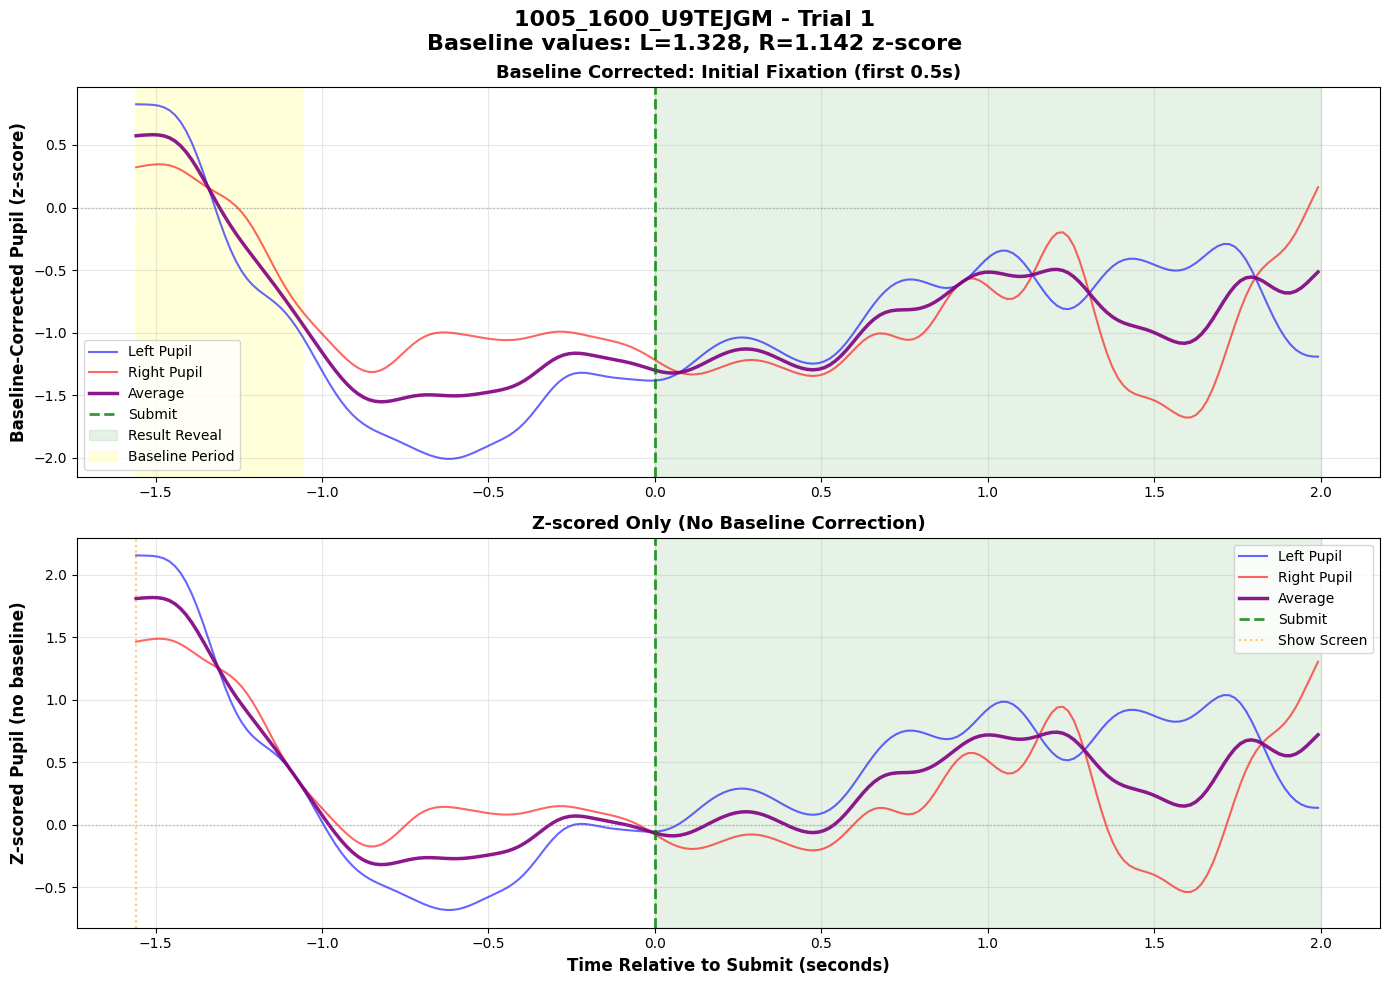


Plotting multiple trials: [1, 3, 4, 5, 6, 7]...


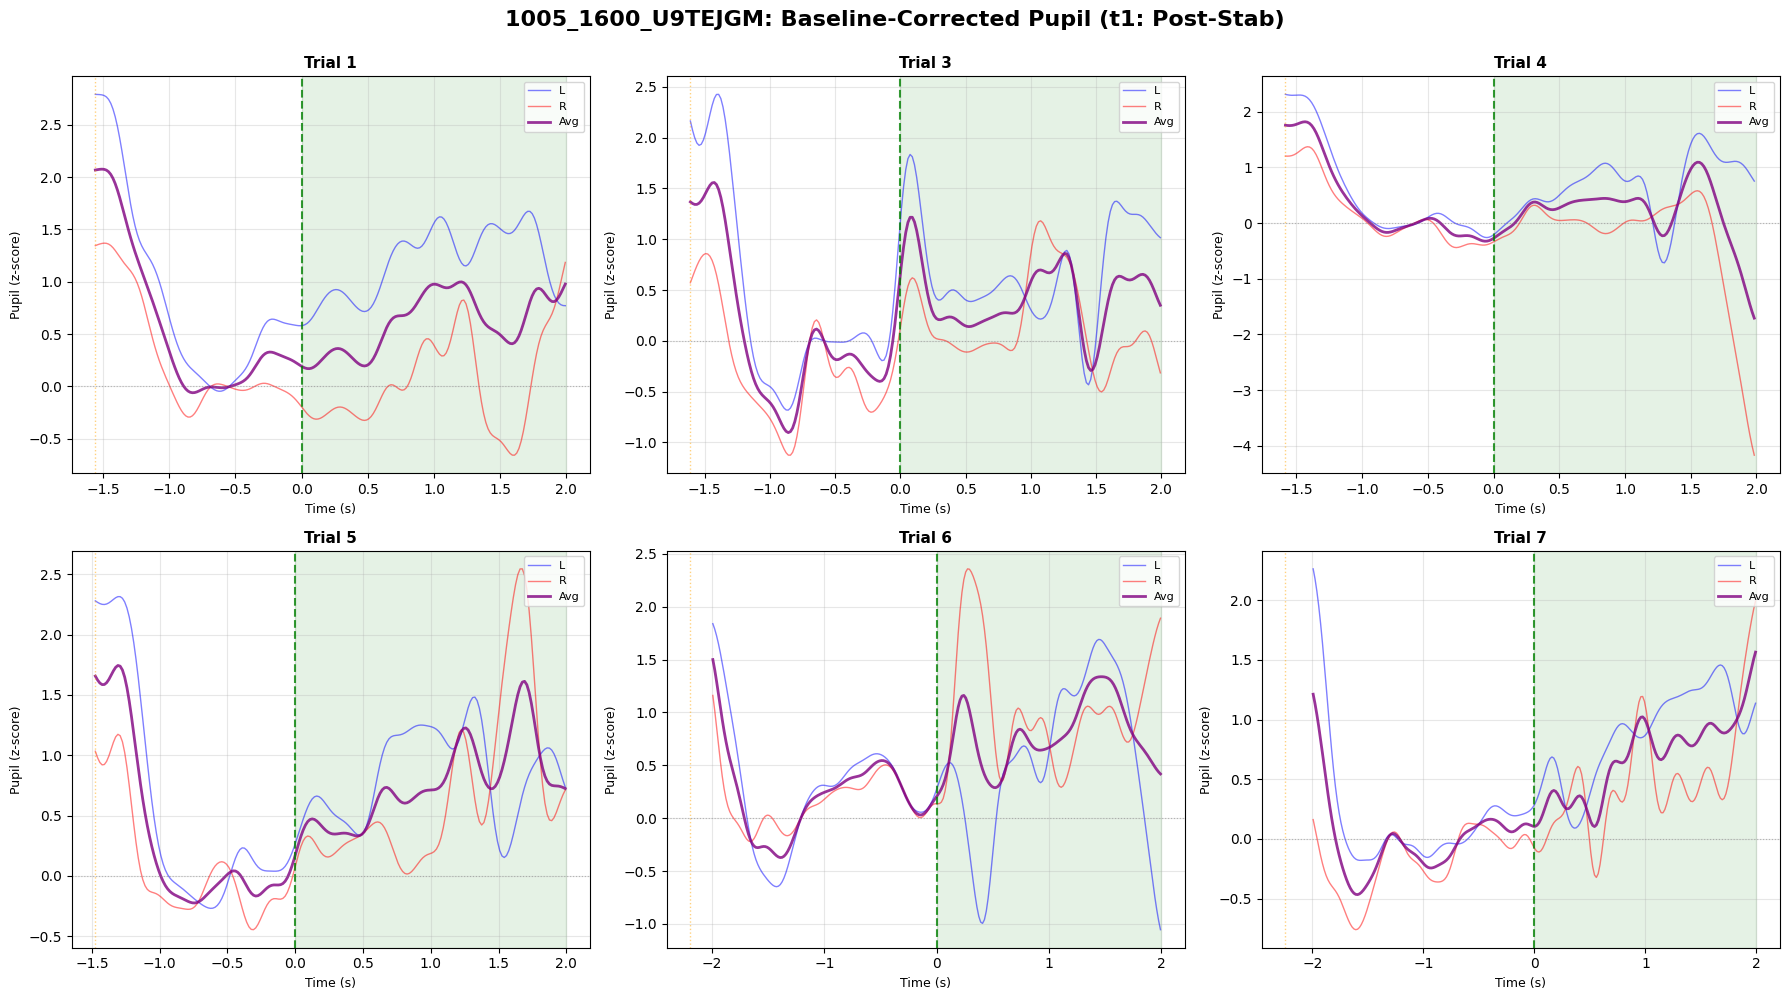


Comparing baseline methods for trial 1...


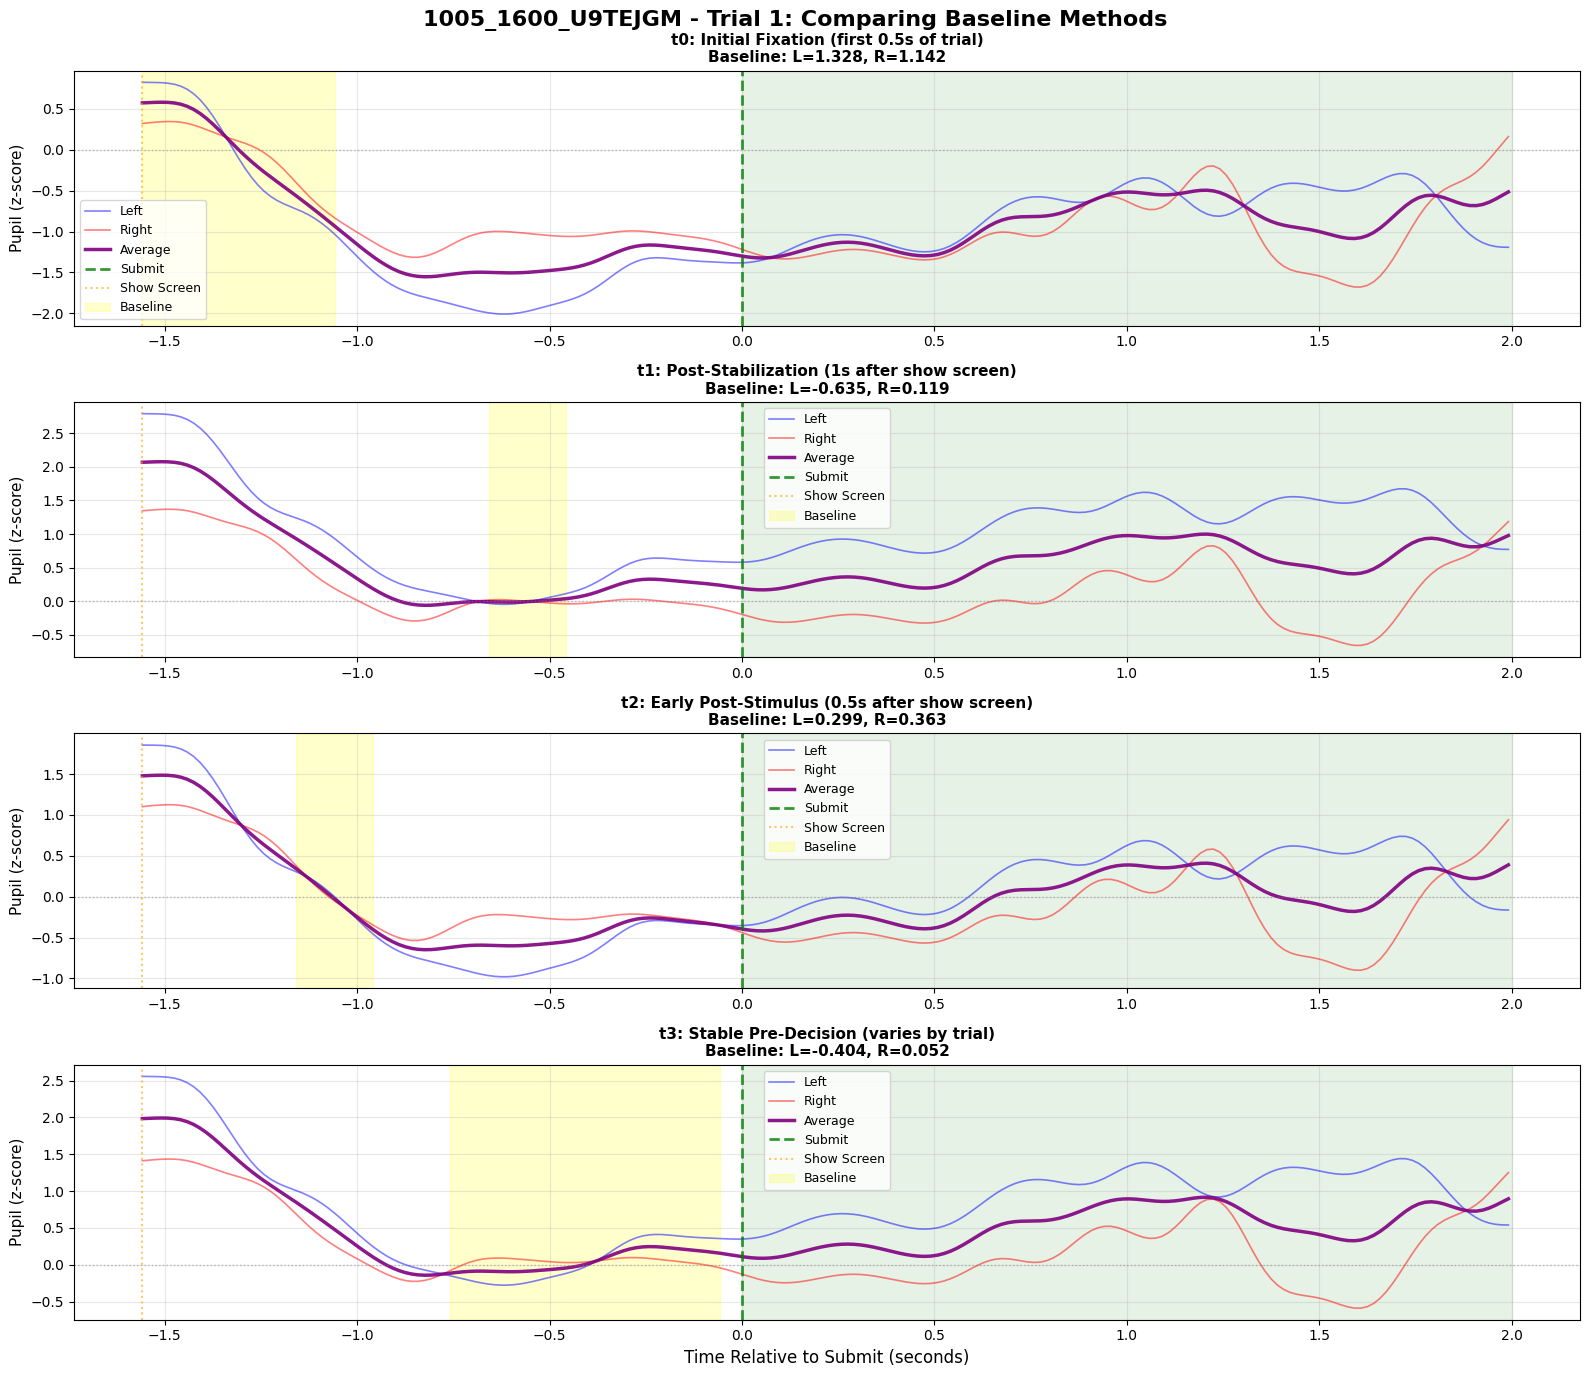


Plotting grand average...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (52,) + inhomogeneous part.

In [ ]:
# Set your directories
JSON_DIR = '/Users/pranmodu/Projects/columbia/liinc/data/json'
PKL_DIR = '/Users/pranmodu/Projects/columbia/liinc/data/eye'
VALIDATION_OUTPUT_DIR = '/Users/pranmodu/Projects/columbia/liinc/data/results/validation'
PREPROCESSING_OUTPUT_DIR = '/Users/pranmodu/Projects/columbia/liinc/data/results/preprocessing'

# Step 1: Run validation on all subjects
print("="*80)
print("STEP 1: VALIDATION")
print("="*80)

validation_results = validate_all_subjects(
    json_dir=JSON_DIR,
    pkl_dir=PKL_DIR,
    output_dir=VALIDATION_OUTPUT_DIR
)

# Step 2: Run preprocessing on all validated subjects
print("\n" + "="*80)
print("STEP 2: PREPROCESSING")
print("="*80)

preprocessing_results = process_all_subjects(
    json_path=JSON_DIR,
    pkl_path=PKL_DIR,
    validation_results_dir=VALIDATION_OUTPUT_DIR,
    output_dir=PREPROCESSING_OUTPUT_DIR
)

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"Validation results saved in: {VALIDATION_OUTPUT_DIR}")
print(f"Preprocessing results saved in: {PREPROCESSING_OUTPUT_DIR}")

# Step 3: Load and visualize results for a subject
print("\n" + "="*80)
print("STEP 3: VISUALIZATION EXAMPLE")
print("="*80)

# Load preprocessing results for one subject
subject_id = '1005_1600_U9TEJGM'  # Change to your subject
results_file = f'{PREPROCESSING_OUTPUT_DIR}/preprocessing_{subject_id}.json'

with open(results_file, 'r') as f:
    results = json.load(f)

# Get list of valid trials
valid_trials = list(results['trial_data'].keys())
print(f"Subject {subject_id} has {len(valid_trials)} preprocessed trials")

# Plot single trial
if len(valid_trials) > 0:
    trial_idx = int(valid_trials[0])
    print(f"\nPlotting trial {trial_idx}...")
    plot_preprocessed_trial(results, trial_idx, method='t0_initial_fixation')

# Plot multiple trials
if len(valid_trials) >= 6:
    trial_indices = [int(t) for t in valid_trials[:6]]
    print(f"\nPlotting multiple trials: {trial_indices}...")
    plot_preprocessed_multiple_trials(results, trial_indices, 
                                        method='t1_post_stabilization')

# Compare baseline methods
if len(valid_trials) > 0:
    trial_idx = int(valid_trials[0])
    print(f"\nComparing baseline methods for trial {trial_idx}...")
    compare_baseline_methods(results, trial_idx)

# Grand average
print(f"\nPlotting grand average...")
plot_grand_average(results, method='t3_stable_pre_decision')

print("\n" + "="*80)
print("ALL DONE!")
print("="*80)